# Reconocimiento de caracteres

In [ ]:
#Librerías
import cv2
import os
import torch
import torchvision
import numpy as np
from torch import nn,optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from google.colab import drive, files
from torch.utils.data import DataLoader,Subset,ConcatDataset

## Función LeNet

In [ ]:
class LeNet_NClasses_batchnorm(nn.Module):
    def __init__(self,nclasses):
        super(LeNet_NClasses_batchnorm,self).__init__()
        self.conv1 = nn.Conv2d(1,6,kernel_size = 5, stride = 1, padding=2)
        self.bn1 = nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(6,16,kernel_size = 5, stride = 1, padding=0)
        self.bn2 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(kernel_size=2,stride = 2)
        self.fc1 = nn.Linear(in_features=16*5*5, out_features=120)
        self.bn3 = nn.BatchNorm1d(120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.bn4 = nn.BatchNorm1d(84)
        self.fc3 = nn.Linear(in_features=84, out_features=nclasses)

    def forward(self,x):
        x = F.relu(self.bn1(self.conv1(x.view(-1,1,28,28))))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = x.view(x.size(0),-1)
        x = F.relu(self.bn3(self.fc1(x)))
        x = F.relu(self.bn4(self.fc2(x)))
        x = F.relu(self.fc3(x))
        x = x.view(x.size(0),-1)
        return x

## Funciones de segmentación

In [ ]:
def binarize(imagen,size_filtro = 21):
    imagen = cv2.cvtColor(imagen.copy(), cv2.COLOR_RGB2GRAY)
    imagen = cv2.GaussianBlur(imagen,(21,21),0)
    _,imagen = cv2.threshold(imagen,0,255,cv2.THRESH_OTSU | cv2.THRESH_BINARY )

    # Si la imagen es predominantemente blanca, invierto los colores
    fraccion_blanca = np.sum(imagen)/(255*imagen.shape[0]*imagen.shape[0])
    if fraccion_blanca > 0.5:
        imagen = 255 - imagen
    return imagen

In [ ]:
def padding_cuadrado(imagen,size_deseado,padding=0):

    alto,ancho = imagen.shape
    lado_maximo = np.max(imagen.shape)
    # Factor de redimensionamiento
    #f_rees = (size_deseado - 2*padding)/lado_maximo

    # Rellenar con ceros el lado más corto para obtener una imagen cuadrada
    if alto > ancho:
        imagen_rellenada = cv2.copyMakeBorder(imagen,0,0,(alto-ancho)//2,alto-ancho - (alto-ancho)//2,cv2.BORDER_CONSTANT)
    else:
        imagen_rellenada = cv2.copyMakeBorder(imagen,(ancho-alto)//2,ancho-alto - (ancho-alto)//2,0,0,cv2.BORDER_CONSTANT)

    # Agregar relleno a todos los lados
    if padding > 0:
        p_reescalado = int(np.round(lado_maximo*padding/(size_deseado-2*padding)))
        imagen_rellenada = cv2.copyMakeBorder(imagen_rellenada,p_reescalado,p_reescalado,p_reescalado,p_reescalado,cv2.BORDER_CONSTANT)

    #Redimensionar al tamaño deseado
    imagen_rellenada = cv2.resize(imagen_rellenada,(size_deseado,size_deseado))
    return imagen_rellenada

In [ ]:
def segmentar_caracteres(mi_imagen,minsize=512,size_deseado = 28,padding=2):

    # Encontrar contornos
    contours,_ = cv2.findContours(mi_imagen.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    segmentos = []

    for c in contours:
        bbox = cv2.boundingRect(c)
        if bbox[2]*bbox[3] >= minsize:
            subimagen = mi_imagen[bbox[1]:bbox[1]+bbox[3],bbox[0]:bbox[0]+bbox[2]]
            subimagen = padding_cuadrado(subimagen,size_deseado=28,padding=padding)
            segmentos.append((bbox,subimagen))

    return segmentos

In [ ]:
def predecir_clase(mi_modelo,imagen):

    # remodelar, normalizar y convertir a torch.tensor
    #x = np.reshape(imagen,(28*28,1))
    x = imagen.copy()
    x = x.astype(float)/255.0
    x = torch.tensor(x,dtype=torch.float32)

    # alimentar a la red
    with torch.no_grad():
        mi_modelo = mi_modelo.eval()
        probs = F.softmax(mi_modelo(x),dim=1).numpy().squeeze()

    clase_predicha = np.argmax(probs).astype(int)

    return clase_predicha,probs[clase_predicha]

In [ ]:
def detectar_y_etiquetar(mi_modelo,imagen,labels,thresh = 0.0):

    imagen = imagen.copy()
    for bbox,subimagen in segmentar_caracteres(binarize(imagen)):
        ClassDef,prob = predecir_clase(mi_modelo,subimagen)
        if ClassDef >= len(labels) or prob < thresh:
            continue
        label = labels[ClassDef]
        imagen = cv2.rectangle(imagen, bbox,(255,0,0), 5)
        cv2.putText(imagen,label,(bbox[0],bbox[1]-50),cv2.FONT_HERSHEY_SIMPLEX,3,(255,0,0),7)
    return imagen

## Funciones de train

In [ ]:
def entrenar_red_gd(n_epocas,net,carga_datos_train,lr):

    funcion_perdida = F.cross_entropy
    opt = optim.SGD(net.parameters(),lr=lr)
    print("learning rate = " + str(lr))
    for epoch in range(n_epocas):
        print("epoch "+str(epoch+1)+"/"+str(n_epocas)+" ... ",end="")
        net.train()
        for ii,(xb,yb) in enumerate(carga_datos_train):
            loss = funcion_perdida(net(xb),yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
            #print("batch "+str(ii+1))

        net.eval()

        with torch.no_grad():
            train_loss = sum(funcion_perdida(net(xb),yb) for xb,yb in carga_datos_train)
            train_loss /= len(carga_datos_train)
            print("training loss = "+str(train_loss.numpy()))

In [ ]:
def accuracy(red,data_loader):

    n_correctos = 0
    n_total = 0
    red.eval()
    with torch.no_grad():
        for x_batch,y_batch in data_loader:
            pred = red(x_batch)
            pred = torch.argmax(pred,dim=1)
            n_correctos += (pred == y_batch).float().sum().numpy()
            n_total += x_batch.size(0)

    return n_correctos/n_total

In [ ]:
def descartar_muestras_nulas(dataset):

    indices = []
    for (ii,sample) in enumerate(dataset):
        target = sample[1]
        if target is not None:
            indices.append(ii)

    return Subset(dataset,indices)

In [ ]:
#Las imágenes deben girarse 90° en el sentido de las agujas del reloj y girarse a lo largo del eje vertical.
emnist_imagen_transform = torchvision.transforms.Compose(
    [
     torchvision.transforms.ToTensor(),
     torchvision.transforms.Lambda(lambda x: x.transpose(1,2))
    ]
)

In [ ]:
def cargar_digitos_mnist_bg(batch_size = 128):

    def reetiquetar_clase_letra(class_idx):
        excluded_letters_idx = [6,8,11,14,16]
        if class_idx in excluded_letters_idx:
            return None
        if class_idx >= 10:
            return 10


# Cargar conjuntos de datos EMNIST y MNIST
    background_train = torchvision.datasets.EMNIST(root='./data',
                                       train=True,
                                       download=True,
                                       split = 'letters',
                                       transform = emnist_imagen_transform,
                                       target_transform = reetiquetar_clase_letra)



    background_test = torchvision.datasets.EMNIST(root='./data',
                                           train=False,
                                           download=True,
                                           split = 'letters',
                                           transform = emnist_imagen_transform,
                                           target_transform = reetiquetar_clase_letra)


    mnist_train = torchvision.datasets.EMNIST(root='./data',
                                       train=True,
                                       download=True,
                                       split = 'mnist',
                                       transform = emnist_imagen_transform)



    mnist_test = torchvision.datasets.EMNIST(root='./data',
                                           train=False,
                                           download=True,
                                           split = 'mnist',
                                           transform = emnist_imagen_transform)

    # Descartar letras no deseadas del conjunto de datos de fondo
    background_train = descartar_muestras_nulas(background_train)
    background_test = descartar_muestras_nulas(background_test)

     # Fusionar datos de fondo y dígitos en un nuevo conjunto de datos
    train_ds = ConcatDataset([mnist_train,background_train])
    test_ds = ConcatDataset([mnist_test,background_test])


     #Crear cargadores de datos y mezclar todo...
    carga_datos_train = torch.utils.data.DataLoader(train_ds,
                                          batch_size=batch_size,
                                          shuffle=True)

    test_dl = torch.utils.data.DataLoader(test_ds,
                                          batch_size=batch_size,
                                          shuffle=True)

    return carga_datos_train,test_dl

In [ ]:
def cargar_mayusculas(batch_size = 128):

    def reetiquetar_clases(class_idx):
        if 10 <= class_idx <= 35:
            return class_idx - 10
        return None



    train_ds = torchvision.datasets.EMNIST(root='./data',
                                           train=True,
                                           download=True,
                                           split = 'byclass',
                                           transform = emnist_imagen_transform,
                                           target_transform = reetiquetar_clases)



    test_ds = torchvision.datasets.EMNIST(root='./data',
                                           train=False,
                                           download=True,
                                           split = 'byclass',
                                           transform = emnist_imagen_transform,
                                           target_transform = reetiquetar_clases)

    # Descartar caracteres no deseados del conjunto de datos
    train_ds = descartar_muestras_nulas(train_ds)
    test_ds = descartar_muestras_nulas(test_ds)


   # Crear cargadores de datos y mezclar todo...
    carga_datos_train = torch.utils.data.DataLoader(train_ds,
                                          batch_size=batch_size,
                                          shuffle=True)

    test_dl = torch.utils.data.DataLoader(test_ds,
                                          batch_size=batch_size,
                                          shuffle=True)

    return carga_datos_train,test_dl


In [ ]:
from google.colab import drive

# Monta tu Google Drive
drive.mount('/content/drive')

# Ruta en Google Drive donde quieres guardar y cargar los modelos
PATH_MODELS = '/content/drive/My Drive/DATA_DEMO/pth/'

# Define la función de entrenamiento para las letras mayúsculas
def entrenar_mayus(state_dict_path="lenet_caps_parameters_caliz.pth"):
    print("LeNet for upper case letters")
    print("loading data ... ", end="")
    caps_carga_datos_train, caps_test_dl = cargar_mayusculas()
    print("done")

    torch.manual_seed(1)
    cnn_mayus = LeNet_NClasses_batchnorm(26)

    entrenar_red_gd(n_epocas=20,
                      net=cnn_mayus,
                      carga_datos_train=caps_carga_datos_train,
                      lr=0.1)

    print("evaluating...")
    print("training accuracy: " + str(accuracy(cnn_mayus, caps_carga_datos_train)))
    print("test accuracy: " + str(accuracy(cnn_mayus, caps_test_dl)))

    torch.save(cnn_mayus.state_dict(), PATH_MODELS + state_dict_path)


Mounted at /content/drive


In [ ]:
# Llamada a la función de entrenamiento
entrenar_mayus()

LeNet for upper case letters
loading data ... Downloading https://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/gzip.zip to ./data/EMNIST/raw/gzip.zip


100%|██████████| 561753746/561753746 [00:18<00:00, 30217541.79it/s]


Extracting ./data/EMNIST/raw/gzip.zip to ./data/EMNIST/raw
done
learning rate = 0.1
epoch 1/20 ... training loss = 0.10952202
epoch 2/20 ... training loss = 0.11091463
epoch 3/20 ... training loss = 0.075799376
epoch 4/20 ... training loss = 0.06931345
epoch 5/20 ... training loss = 0.04853091
epoch 6/20 ... training loss = 0.08959581
epoch 7/20 ... training loss = 0.045426
epoch 8/20 ... training loss = 0.038098034
epoch 9/20 ... training loss = 0.03812874
epoch 10/20 ... training loss = 0.03504948
epoch 11/20 ... training loss = 0.061309345
epoch 12/20 ... training loss = 0.037034832
epoch 13/20 ... training loss = 0.038220894
epoch 14/20 ... training loss = 0.027330253
epoch 15/20 ... training loss = 0.023340084
epoch 16/20 ... training loss = 0.023051191
epoch 17/20 ... training loss = 0.024069214
epoch 18/20 ... training loss = 0.019787377
epoch 19/20 ... training loss = 0.028977474
epoch 20/20 ... training loss = 0.017438699
evaluating...
training accuracy: 0.9951576540818594
tes

## Ahora sí con las imágenes

In [ ]:
# Definir las rutas de las imágenes en Google Drive
image_paths = {
    "digits": "/content/drive/MyDrive/DATA_DEMO/dataset/digits.jpg",
    "capsletters": "/content/drive/MyDrive/DATA_DEMO/dataset/latin_caps.jpg",
    "greek": "/content/drive/MyDrive/DATA_DEMO/dataset/greek_lower.jpg",
    "nonalphanum": "/content/drive/MyDrive/DATA_DEMO/dataset/nonalphanum.jpg",
    "pangram": "/content/drive/MyDrive/DATA_DEMO/dataset/pangram.jpg",
    "rana": "/content/drive/MyDrive/DATA_DEMO/dataset/rana.jpg",
    "froggy": "/content/drive/MyDrive/DATA_DEMO/dataset/froggy.jpg",
    "Dani": "/content/drive/MyDrive/DATA_DEMO/dataset/Dani.jpg"
}

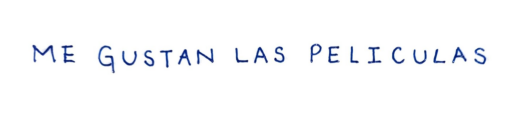

In [ ]:
# Ruta de la imagen que quieres mostrar
image_path = image_paths["Dani"]

# Leer la imagen usando OpenCV
image = cv2.imread(image_path)

# Convertir de BGR a RGB (OpenCV lee las imágenes en formato BGR por defecto)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Mostrar la imagen usando matplotlib
plt.imshow(image)
plt.axis('off')  # Para ocultar los ejes
plt.show()

In [ ]:
# Cargar las imágenes desde las rutas
imagenes = {}
for key, path in image_paths.items():
    imagenes[key] = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

In [ ]:
#Descomentar si quieren verse todas las imágenes
"""for imagen in imagenes.values():
    plt.figure(figsize=(10,10))
    plt.imshow(imagen)
    plt.axis("off")"""

'for imagen in imagenes.values():\n    plt.figure(figsize=(10,10))\n    plt.imshow(imagen)\n    plt.axis("off")'

Aquí cargamos el pth del modelo q entrenamos
---

In [ ]:
LENET_CAPS_PATH = "/content/drive/MyDrive/DATA_DEMO/pth/lenet_caps_parameters_us.pth"

In [ ]:
cnn_mayus = LeNet_NClasses_batchnorm(26)
cnn_mayus.load_state_dict(torch.load(LENET_CAPS_PATH))
cnn_mayus = cnn_mayus.eval()

# Detección de letras

El clasificador ha sido entrenado con las letras mayúsculas de la división **By_Class** del conjunto de datos EMNIST.
Las probabilidades de softmax tienen un umbral de 0,9 para evitar la detección de caracteres que no sean letras latinas mayúsculas. Esto funciona hasta cierto punto.

(-0.5, 1699.5, 368.5, -0.5)

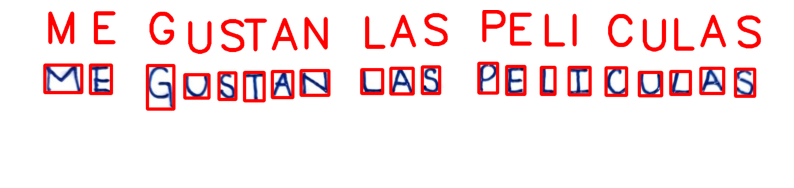

In [ ]:
caps_labels = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"


plt.figure(figsize=(10,10))
plt.imshow(detectar_y_etiquetar(cnn_mayus,imagenes["Dani"],caps_labels,thresh=0.9))
plt.axis("off")

In [ ]:
def detectar_y_crear_string_con_espacios(model, image, labels, thresh=0.6, space_threshold=70):
    segmento_texto = []

    # Obtener las segmentaciones de caracteres
    segmento_caracter = segmentar_caracteres(binarize(image))

    for bbox, subimagen in segmento_caracter:
        # Predecir el carácter y su probabilidad
        caracter, prob = predecir_clase(model, subimagen)

        # Si la probabilidad es mayor al umbral y el carácter está dentro de los límites de los labels
        if caracter < len(labels) and prob >= thresh:
            label = labels[caracter]
            # Agregar el carácter, su posición y su bounding box a la lista
            segmento_texto.append(((bbox[0], bbox[1]), label, bbox))

    # Ordenar los segmentos de texto según sus coordenadas X (de izquierda a derecha)
    segmento_texto.sort(key=lambda x: x[0][0])

    # Agregar espacios si la distancia horizontal entre caracteres supera el umbral y la probabilidad es alta
    texto_ordenado = ''
    for i in range(len(segmento_texto)):
        caracter, label, bbox = segmento_texto[i]
        texto_ordenado += label

        if i < len(segmento_texto) - 1:
          caracter_siguiente_x = segmento_texto[i + 1][0][0]
          caracter_actual_x = bbox[0] + bbox[2]  # Coordenada X del lado derecho de la caja delimitadora actual
          if caracter_siguiente_x - caracter_actual_x > space_threshold and segmento_texto[i + 1][1] != ' ':  # Evitar espacios duplicados
            texto_ordenado += ' '  # Agregar espacio si la distancia es mayor que el umbral y no es un espacio ya agregado

    return texto_ordenado

imagen_seleccionada = "Dani"
# Llamada para obtener el texto con espacios añadidos entre cajas más separadas de 'rana'
texto_obtenido = detectar_y_crear_string_con_espacios(cnn_mayus, imagenes[imagen_seleccionada], caps_labels, thresh=0.6, space_threshold=70)
print(f"Texto reconocido en '{imagen_seleccionada}' con espacios añadidos (sensible): {texto_obtenido}")


Texto reconocido en 'Dani' con espacios añadidos (sensible): ME GUSTAN LAS PELICULAS


TRADUCCIÓN AUTOMÁTICA

In [ ]:
!pip install keras-transformer

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for keras-transformer: filename=keras_transformer-0.40.0-py3-none-any.whl size=12286 sha256=c8a01bd540a46dda2b9f24c1928ce00ffd9133ca40b275672c4199de5eb1be8d
  Stored in directory: /root/.cache/pip/wheels/f2/cb/22/75a0ad376129177f7c95c0d91331a18f5368fd657f4035ba7c
  Created wheel for keras-embed-sim: filename=keras_embed_sim-0.10.0-py3-none-any.whl size=3943 sha256=4998c557a99e64ff77e5da6e9824c524d7dbf7d11bbf3b1e76ace20d18d31cdf
  Stored in directory: /root/.cache/pip/wheels/82/32/c7/fd35d0d1b840a6c7cbd4343f808d10d0f7b87d271a4dbe796f
  Created wheel for keras-layer-normalization: filename=keras_layer_normalization-0.16.0-py3-none-any.whl size=4653 sha256=c337f061630d4b646bfa4f73ea8c63cae6f

In [ ]:
import numpy as np
from keras_transformer import get_model, decode  #para implementar el transformer
from pickle import load      #para leer el dataset
from google.colab import drive

In [ ]:
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


LECTURA DEL DATASET

In [ ]:
ruta = '/content/drive/MyDrive/DATA_DEMO/proyecto_traductor/dataset.pkl'  #un archivo pickle nos permite guardar el dataset en estructura de lista

dataset = load(open(ruta, 'rb'))

print(dataset)

[['happy birthday' 'feliz cumpleanos']
 ['go' 've']
 ['go' 'vete']
 ...
 ['a carbon footprint is the amount of carbon dioxide pollution that we produce as a result of our activities some people try to reduce their carbon footprint because they are concerned about climate change'
  'una huella de carbono es la cantidad de contaminacion de dioxido de carbono que producimos como producto de nuestras actividades algunas personas intentan reducir su huella de carbono porque estan preocupados acerca del cambio climatico']
 ['since there are usually multiple websites on any given topic i usually just click the back button when i arrive on any webpage that has popup advertising i just go to the next page found by google and hope for something less irritating'
  'como suele haber varias paginas web sobre cualquier tema normalmente solo le doy al boton de retroceso cuando entro en una pagina web que tiene anuncios en ventanas emergentes simplemente voy a la siguiente pagina encontrada por google

CREACION DE ESPACIO VECTORIAL DE PALABRAS

In [ ]:
"Creamos dos listas de vectores (una para ingles y otra para español), cada vector contiene una palabra/frase del dataset"
englishSpace = []
for sentence in dataset[:,0]:
  englishSpace.append(sentence.split(' '))

spanishSpace = []
for sentence in dataset[:,1]:
 spanishSpace.append(sentence.split(' '))

print(englishSpace[0])

['happy', 'birthday']


In [ ]:
def encoding(space):
  "Esta función crea un diccionario de palabras para un idioma y le asocia un valor numérico a cada una"
  tokensDict = {
      '<PADDING>': 0,    #para rellenar los vectores y que todos sean del mismo tamaño
      '<START>'  : 1,    #indica el inicio de la oración
      '<END>'    : 2,    #indica el final de la oración
  }

  for sentence in space:
    for token in sentence:
      if token not in tokensDict:
        tokensDict[token] = len(tokensDict)

  return tokensDict

In [ ]:
englishDict = encoding(englishSpace)
spanishDict = encoding(spanishSpace)

inverse_englishDict = {a:b for b,a in englishDict.items()}
inverse_spanishDict = {a:b for b,a in spanishDict.items()}

print(englishDict)
print(inverse_englishDict)

{'<PADDING>': 0, '<START>': 1, '<END>': 2, 'happy': 3, 'birthday': 4, 'go': 5, 'hi': 6, 'run': 7, 'who': 8, 'fire': 9, 'help': 10, 'jump': 11, 'stop': 12, 'wait': 13, 'on': 14, 'hello': 15, 'i': 16, 'ran': 17, 'try': 18, 'won': 19, 'oh': 20, 'no': 21, 'relax': 22, 'smile': 23, 'attack': 24, 'get': 25, 'up': 26, 'now': 27, 'got': 28, 'it': 29, 'he': 30, 'hop': 31, 'in': 32, 'hug': 33, 'me': 34, 'fell': 35, 'know': 36, 'left': 37, 'lied': 38, 'lost': 39, 'quit': 40, 'work': 41, 'im': 42, '19': 43, 'listen': 44, 'way': 45, 'really': 46, 'thanks': 47, 'we': 48, 'why': 49, 'ask': 50, 'tom': 51, 'awesome': 52, 'be': 53, 'calm': 54, 'cool': 55, 'fair': 56, 'kind': 57, 'nice': 58, 'beat': 59, 'call': 60, 'us': 61, 'come': 62, 'drop': 63, 'out': 64, 'away': 65, 'home': 66, 'slow': 67, 'goodbye': 68, 'hang': 69, 'came': 70, 'hit': 71, 'hold': 72, 'agree': 73, 'bowed': 74, 'moved': 75, 'slept': 76, 'tried': 77, 'ill': 78, 'fat': 79, 'fit': 80, 'old': 81, 'shy': 82, 'wet': 83, 'its': 84, 'ok': 85,

In [ ]:
"Creamos el vector de cada frase en el dataset homologando el tamaño mediante el padding, también agregamos la palabra clave de inicio (START) y de final (END)"

englishVec = [['<START>'] + words + ['<END>'] for words in englishSpace]
spanishVec = [['<START>'] + words + ['<END>'] for words in spanishSpace]

englishTarget = [words + ['<END>'] for words in englishSpace]
spanishTarget = [words + ['<END>'] for words in spanishSpace]

#El tamaño (len) del vector más grande en el espacio de cada idioma
englishSpace_len = max(map(len, englishVec))
spanishSpace_len = max(map(len, spanishVec))


#rellenamos de ceros (padding)
englishVec = [words + ['<PADDING>']*(englishSpace_len-len(words))
                for words in englishVec]
spanishVec = [words + ['<PADDING>']*(spanishSpace_len-len(words))
                for words in spanishVec]

spanishTarget = [words + ['<PADDING>']*(spanishSpace_len-len(words)) for words in spanishTarget]
englishTarget = [words + ['<PADDING>']*(englishSpace_len-len(words)) for words in englishTarget]

print(englishVec[0])
print(spanishTarget[0])
print(spanishSpace_len)


['<START>', 'happy', 'birthday', '<END>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>']
['feliz', 'cumpleanos', '<END>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<PADDING>', '<

EMBEDDING

In [ ]:
"Los vectores para cada frase del dataset pasan a tener una representación numérica"

englishEncoding = [list(map(lambda x: englishDict[x], words)) for words in englishVec]
spanishEncoding = [list(map(lambda x: spanishDict[x], words)) for words in spanishVec]

spanishTarget_encoding = [list(map(lambda x: spanishDict[x], words)) for words in spanishTarget]
englishTarget_encoding = [list(map(lambda x: englishDict[x], words)) for words in englishTarget]

print(englishEncoding[0])
print(spanishTarget_encoding[0:2])

[1, 3, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[[3, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [5, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]


ENTRENAMIENTO DEL MODELO

In [ ]:
english_to_spanish = get_model(
    token_num = max(len(englishEncoding), len(spanishEncoding)),
    embed_dim = 32,
    encoder_num = 2,
    decoder_num = 2,
    head_num = 4,
    hidden_dim = 128,
    dropout_rate = 0.05,
    use_same_embed = False
)

english_to_spanish.compile('adam', 'sparse_categorical_crossentropy')
english_to_spanish.summary()

spanish_to_english = get_model(
    token_num = max(len(spanishEncoding), len(englishEncoding)),
    embed_dim = 32,
    encoder_num = 2,
    decoder_num = 2,
    head_num = 4,
    hidden_dim = 128,
    dropout_rate = 0.05,
    use_same_embed = False
)

spanish_to_english.compile('adam', 'sparse_categorical_crossentropy')
spanish_to_english.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Encoder-Input (InputLayer)  [(None, None)]               0         []                            
                                                                                                  
 Encoder-Token-Embedding (E  [(None, None, 32),           3806912   ['Encoder-Input[0][0]']       
 mbeddingRet)                 (118966, 32)]                                                       
                                                                                                  
 Encoder-Embedding (TrigPos  (None, None, 32)             0         ['Encoder-Token-Embedding[0][0
 Embedding)                                                         ]']                           
                                                                                              

In [69]:
"Entrenamiento de la red"

#de ingles a español
x = [np.array(englishEncoding), np.array(spanishEncoding)]
y = np.array(spanishTarget_encoding)

english_to_spanish.fit(x, y, epochs = 15, batch_size = 32)

#de español a ingles
x = [np.array(spanishEncoding), np.array(englishEncoding)]
y = np.array(englishTarget_encoding)

spanish_to_english.fit(x, y, epochs = 15, batch_size = 32)

Epoch 1/15
2273/3718 [=================>............] - ETA: 1:33:53 - loss: 4.7322

KeyboardInterrupt: ignored

FUNCIONES PARA TRADUCCION

In [ ]:
def translate_english_to_spanish(sentence):
  sentenceTokens = [tokens + ['<END>', '<PADDING>'] for tokens in [sentence.split(' ')] ]
  tr_input = [list(map(lambda x: englishDict[x], tokens)) for tokens in sentenceTokens][0]
  decoded = decode(
      english_to_spanish,
      tr_input,
      start_token = spanishDict['<START>'],
      end_token   = spanishDict['<END>'],
      pad_token   = spanishDict['<PADDING>']
  )

  print('Frase original: {}'.format(sentence))
  print('Traducción: {}'.format(' '.join(map(lambda x: inverse_spanishDict[x], decoded[1:-1]))))


def translate_spanish_to_english(sentence):
  sentenceTokens = [tokens + ['<END>', '<PADDING>'] for tokens in [sentence.split(' ')] ]
  tr_input = [list(map(lambda x: spanishDict[x], tokens)) for tokens in sentenceTokens][0]
  decoded = decode(
      spanish_to_english,
      tr_input,
      start_token = englishDict['<START>'],
      end_token   = englishDict['<END>'],
      pad_token   = englishDict['<PADDING>']
  )

  print('Frase original: {}'.format(sentence))
  print('Traducción: {}'.format(' '.join(map(lambda x: inverse_englishDict[x], decoded[1:-1]))))

In [ ]:
original_language = "ingles"   #aqui debe indicarse de que idioma a que idioma traducir

if original_language == "ingles":
  translate_english_to_spanish(texto_obtenido)

else:
  translate_spanish_to_english(texto_obtenido)